In [1]:
# run in Colab/local
import os, json, re
import numpy as np, pandas as pd
from pathlib import Path

RAW = Path("C:\\Users\\aaron\\cancerchemo\\data\\raw")
PROC = Path("C:\\Users\\aaron\\cancerchemo\\data\\processed")
ART = Path("C:\\Users\\aaron\\cancerchemo\\artifacts\\")
for p in [PROC, ART]:
    p.mkdir(parents=True, exist_ok=True)


In [2]:
mut_fn = RAW / "data_mutations_extended.txt"
cna_fn = RAW / "data_CNA.txt"
pat_fn = RAW / "data_clinical_patient.txt"      # or patient_level_dataset.csv synonyms
sample_fn = RAW / "data_clinical_sample.txt"
regimen_fn = RAW / "regimen_cancer_level_dataset.csv"
panel_test_fn = RAW / "cancer_panel_test_level_dataset.csv"
supp_surv_fn = RAW / "data_clinical_supp_survival_treatment.txt"

# load
mut_df = pd.read_csv(mut_fn, sep="\t", low_memory=False)
print("mutations rows:", len(mut_df))
cna_df = pd.read_csv(cna_fn, sep="\t", low_memory=False)
print("CNA shape:", cna_df.shape)
pat_df = pd.read_csv(pat_fn, sep="\t", low_memory=False)
sample_df = pd.read_csv(sample_fn, sep="\t", low_memory=False)
reg_df = pd.read_csv(regimen_fn, low_memory=False)
panel_test_df = pd.read_csv(panel_test_fn, low_memory=False)
supp_surv_df = pd.read_csv(supp_surv_fn, sep="\t", low_memory=False)
print("loaded all")


mutations rows: 17472
CNA shape: (964, 1779)
loaded all
loaded all


In [3]:
# keep only coding, non-silent variants
# Column names may be 'Variant_Classification' or 'Consequence' -> check
vc_col = None
for c in ["Variant_Classification","Consequence","variant_classification"]:
    if c in mut_df.columns:
        vc_col = c; break
print("variant classification column:", vc_col)

# drop synonyms / silent consequences
bad = set(['Silent','Intron','3\'UTR','5\'UTR','RNA','Intron/Exon','IGR','lincRNA'])
if vc_col is not None:
    mut_filt = mut_df[~mut_df[vc_col].isin(bad)]
else:
    mut_filt = mut_df.copy()

# Standardize gene col names
if 'Hugo_Symbol' in mut_filt.columns:
    mut_filt['gene'] = mut_filt['Hugo_Symbol']
elif 'Hugo Symbol' in mut_filt.columns:
    mut_filt['gene'] = mut_filt['Hugo Symbol']
else:
    raise RuntimeError("Gene column not found in mutation file.")

# Sample barcode col
samp_col = None
for c in ['Tumor_Sample_Barcode','tumor_sample_barcode','SAMPLE_ID','Tumor_Sample_Barcode']:
    if c in mut_filt.columns:
        samp_col = c; break
if samp_col is None:
    raise RuntimeError("Sample id column not found in mutation file.")
mut_filt = mut_filt[[samp_col,'gene']].dropna()

# pivot: binary presence
mut_pivot = (mut_filt
             .assign(flag=1)
             .drop_duplicates([samp_col,'gene'])
             .pivot(index=samp_col, columns='gene', values='flag')
             .fillna(0).astype(int))
mut_pivot.index.name = "Sample_ID"
print("mutation matrix shape:", mut_pivot.shape)
mut_pivot.to_csv(PROC / "mutations_matrix.csv")


variant classification column: Variant_Classification
mutation matrix shape: (1943, 696)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30268\1548584930.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_filt['gene'] = mut_filt['Hugo_Symbol']


In [4]:
# data_CNA.txt: rows=genes, cols=samples
cna = cna_df.copy()
if 'Hugo_Symbol' not in cna.columns:
    raise RuntimeError("data_CNA missing Hugo_Symbol header")
cna = cna.set_index('Hugo_Symbol')
# transpose to sample rows
cna_t = cna.transpose().reset_index().rename(columns={'index':'Sample_ID'})
# sample IDs likely like GENIE-DFCI-003908-234520; keep as-is
print("CNA transposed shape:", cna_t.shape)
cna_t.to_csv(PROC / "cna_matrix.csv", index=False)


CNA transposed shape: (1778, 965)


In [5]:
# Inspect sample_df columns
print(sample_df.columns.tolist())
# find column names
if 'Sample Identifier' in sample_df.columns:
    sid_col = 'Sample Identifier'
elif 'SAMPLE_ID' in sample_df.columns:
    sid_col = 'SAMPLE_ID'
else:
    # try common names
    sid_col = [c for c in sample_df.columns if 'sample' in c.lower()][0]

if 'Patient Identifier' in sample_df.columns:
    pid_col = 'Patient Identifier'
else:
    pid_col = [c for c in sample_df.columns if 'patient' in c.lower()][0]

sample_map = sample_df[[sid_col, pid_col]].dropna().drop_duplicates()
sample_map.columns = ['Sample_ID','Patient_ID']
print("sample->patient rows:", len(sample_map))
sample_map.to_csv(PROC / "sample_to_patient.csv", index=False)


['ONCOTREE_CODE', 'SAMPLE_TYPE_DETAILED', 'SEQ_ASSAY_ID', 'AGE_AT_SEQUENCING', 'SAMPLE_ID', 'PATIENT_ID', 'PDL1_POSITIVE_ANY', 'PDL1_TESTING', 'CPT_SEQ_DATE']
sample->patient rows: 2004


In [6]:
pat_df = pd.read_csv(RAW / "data_clinical_patient.txt", sep="\t", low_memory=False)

print(f"Loaded {len(pat_df)} patients")
print(f"Available columns: {len(pat_df.columns)}")

# Standardize patient ID
pat_meta = pat_df.copy()
pat_meta['Patient_ID'] = pat_meta['PATIENT_ID'].astype(str).str.strip()

# Extract ALL available clinical columns with EXACT matches
# Based on data_clinical_patient.txt structure
exact_column_map = {
    # Demographics (continuous)
    'BIRTH_YEAR': 'birth_year',
    
    # Demographics (categorical)
    'SEX': 'sex',
    'ETHNICITY': 'ethnicity',
    'PRIMARY_RACE': 'race',
    
    # Cancer characteristics (categorical)
    'CA_GRADE': 'tumor_grade',
    'CA_HISTOLOGY': 'histology_detailed',
    'CA_HIST_ADENO_SQUAMOUS': 'histology_type',
    'STAGE_DX': 'stage_at_diagnosis',
    'CA_TX_PRE_PATH_STAGE': 'pre_treatment_stage',
    
    # Smoking/Tobacco (categorical)
    'CA_LUNG_CIGARETTE': 'smoking_history',
    
    # Metastasis status (categorical/binary)
    'CA_DMETS_YN': 'distant_mets',
    'DMETS_DX_ADRENAL': 'mets_adrenal',
    'DMETS_DX_BONE': 'mets_bone',
    'DMETS_DX_BRAIN': 'mets_brain',
    'DMETS_DX_LIVER': 'mets_liver',
    'DMETS_DX_LUNG': 'mets_lung',
    'DMETS_DX_LYMPH': 'mets_lymph',
    'DMETS_DX_PLEURA': 'mets_pleura',
    'DMETS_DX_SUBC_TISSUE': 'mets_subq_tissue',
    'DMETS_DX_OTHER': 'mets_other',
    
    # Tumor characteristics (categorical)
    'NAACCR_BEHAVIOR_CD': 'tumor_behavior',
    'NAACCR_LATERALITY_CD': 'tumor_laterality',
    
    # Treatment center and counts (categorical/continuous)
    'CENTER': 'treatment_center',
    'N_CANCERS': 'n_cancers',
    'N_CANCERS_INDEX': 'n_cancers_index',
    'N_REGIMENS_PT': 'n_regimens',
    'N_IMAGING_REPORTS_PT': 'n_imaging_reports',
    'N_SCANS_CT_PT': 'n_ct_scans',
    'N_SCANS_MRI_PT': 'n_mri_scans',
    'N_SCANS_PET_CT_PT': 'n_pet_scans',
    'N_PATH_REPORTS_PT': 'n_path_reports',
    'N_MD_NOTES_PT': 'n_md_notes'
}

# Find which columns actually exist
final_cols = ['Patient_ID']
col_mapping = {}
for orig_col, std_name in exact_column_map.items():
    if orig_col in pat_meta.columns:
        col_mapping[orig_col] = std_name
        final_cols.append(orig_col)

print(f"\n{'='*60}")
print(f"Found {len(col_mapping)} clinical features:")
print(f"{'='*60}")

print("\n📊 DEMOGRAPHICS:")
for orig, std in [(k, v) for k, v in col_mapping.items() if v in ['birth_year', 'sex', 'ethnicity', 'race']]:
    print(f"  ✓ {std}: {orig}")

print("\n🏥 CANCER CHARACTERISTICS:")
for orig, std in [(k, v) for k, v in col_mapping.items() if 'grade' in v or 'histology' in v or 'stage' in v]:
    print(f"  ✓ {std}: {orig}")

print("\n🚬 SMOKING:")
for orig, std in [(k, v) for k, v in col_mapping.items() if 'smoking' in v]:
    print(f"  ✓ {std}: {orig}")

print("\n🔬 METASTASES:")
for orig, std in [(k, v) for k, v in col_mapping.items() if 'mets' in v]:
    print(f"  ✓ {std}: {orig}")

print("\n🏛️ TUMOR CHARACTERISTICS:")
for orig, std in [(k, v) for k, v in col_mapping.items() if 'tumor_' in v or 'behavior' in v or 'laterality' in v]:
    print(f"  ✓ {std}: {orig}")

print("\n📈 TREATMENT/SCAN COUNTS:")
for orig, std in [(k, v) for k, v in col_mapping.items() if 'n_' in v or 'center' in v]:
    print(f"  ✓ {std}: {orig}")

# Select relevant columns
if len(final_cols) > 1:
    pat_meta_clean = pat_meta[final_cols].copy()
    # Rename to standardized names
    rename_dict = {orig: std for orig, std in col_mapping.items()}
    pat_meta_clean = pat_meta_clean.rename(columns=rename_dict)
    
    # Calculate age at diagnosis (current year - birth year, or use 2025 as reference)
    if 'birth_year' in pat_meta_clean.columns:
        pat_meta_clean['age_at_diagnosis'] = 2025 - pd.to_numeric(pat_meta_clean['birth_year'], errors='coerce')
    
    # Clean up categorical variables (strip whitespace, handle missing)
    for col in pat_meta_clean.columns:
        if col not in ['Patient_ID', 'birth_year', 'age_at_diagnosis'] and pat_meta_clean[col].dtype == 'object':
            pat_meta_clean[col] = pat_meta_clean[col].astype(str).str.strip()
            # Replace common missing value indicators
            pat_meta_clean[col] = pat_meta_clean[col].replace({
                'nan': np.nan, 'NaN': np.nan, 'NA': np.nan, 'N/A': np.nan, 
                'Unknown': np.nan, 'Not Available': np.nan, '': np.nan
            })
    
    # Drop duplicates (one row per patient)
    pat_meta_clean = pat_meta_clean.drop_duplicates(subset=['Patient_ID'])
    
    print(f"\n{'='*60}")
    print(f"Patient metadata shape: {pat_meta_clean.shape}")
    print(f"{'='*60}")
    
    # Show sample statistics
    print("\n📊 DATA COMPLETENESS:")
    for col in pat_meta_clean.columns:
        if col != 'Patient_ID':
            n_missing = pat_meta_clean[col].isna().sum()
            pct_complete = 100 * (len(pat_meta_clean) - n_missing) / len(pat_meta_clean)
            print(f"  {col}: {pct_complete:.1f}% complete ({len(pat_meta_clean) - n_missing} / {len(pat_meta_clean)})")
    
    # Save
    pat_meta_clean.to_csv(PROC / "patient_metadata.csv", index=False)
    print(f"\n✅ Saved patient_metadata.csv with {len(pat_meta_clean.columns)} features")
    
    print("\n📋 Sample of patient metadata:")
    print(pat_meta_clean.head(3))
    
else:
    print("⚠️  Warning: No standard metadata columns found")
    pat_meta_clean = pat_meta[['Patient_ID']].drop_duplicates()
    pat_meta_clean.to_csv(PROC / "patient_metadata.csv", index=False)

print("\n✅ COMPLETE!")

Loaded 1846 patients
Available columns: 33

Found 32 clinical features:

📊 DEMOGRAPHICS:
  ✓ birth_year: BIRTH_YEAR
  ✓ sex: SEX
  ✓ ethnicity: ETHNICITY
  ✓ race: PRIMARY_RACE

🏥 CANCER CHARACTERISTICS:
  ✓ tumor_grade: CA_GRADE
  ✓ histology_detailed: CA_HISTOLOGY
  ✓ histology_type: CA_HIST_ADENO_SQUAMOUS
  ✓ stage_at_diagnosis: STAGE_DX
  ✓ pre_treatment_stage: CA_TX_PRE_PATH_STAGE

🚬 SMOKING:
  ✓ smoking_history: CA_LUNG_CIGARETTE

🔬 METASTASES:
  ✓ distant_mets: CA_DMETS_YN
  ✓ mets_adrenal: DMETS_DX_ADRENAL
  ✓ mets_bone: DMETS_DX_BONE
  ✓ mets_brain: DMETS_DX_BRAIN
  ✓ mets_liver: DMETS_DX_LIVER
  ✓ mets_lung: DMETS_DX_LUNG
  ✓ mets_lymph: DMETS_DX_LYMPH
  ✓ mets_pleura: DMETS_DX_PLEURA
  ✓ mets_subq_tissue: DMETS_DX_SUBC_TISSUE
  ✓ mets_other: DMETS_DX_OTHER

🏛️ TUMOR CHARACTERISTICS:
  ✓ tumor_grade: CA_GRADE
  ✓ tumor_behavior: NAACCR_BEHAVIOR_CD
  ✓ tumor_laterality: NAACCR_LATERALITY_CD

📈 TREATMENT/SCAN COUNTS:
  ✓ treatment_center: CENTER
  ✓ n_cancers: N_CANCERS
  ✓ n_c

# Genomic matrix df

In [7]:
import numpy as np
import pandas as pd

# load
mut = pd.read_csv(PROC / "mutations_matrix.csv", index_col=0)  # rows = Sample_ID, cols = gene mutation indicators
cna = pd.read_csv(PROC / "cna_matrix.csv")                     # includes 'Sample_ID' column or index
sample_map = pd.read_csv(PROC / "sample_to_patient.csv")       # columns: Sample_ID, Patient_ID

# normalize ids
mut.index = mut.index.astype(str).str.strip()
sample_map['Sample_ID'] = sample_map['Sample_ID'].astype(str).str.strip()
sample_map['Patient_ID'] = sample_map['Patient_ID'].astype(str).str.strip()

# find common samples
common_samples = sorted(list(set(mut.index) & set(sample_map['Sample_ID'])))
print("common_samples:", len(common_samples), " total mut samples:", mut.shape[0])

# subset mut to mapped samples and create Patient_ID column
mut = mut.loc[common_samples].copy()
map_idx = sample_map.set_index('Sample_ID').loc[mut.index]
mut['Patient_ID'] = map_idx['Patient_ID'].values

# --- Ensure mutation columns are numeric 0/1 ---
# identify candidate mutation columns (exclude Patient_ID if present)
mut_cols = [c for c in mut.columns if c != 'Patient_ID']
# coerce to numeric (non-convertible -> NaN), then fill NaN->0, then cast to int
mut[mut_cols] = mut[mut_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# aggregate per patient: OR across samples (max)
patient_mut = mut.groupby('Patient_ID')[mut_cols].max().astype(int)
# prefix mutation columns
patient_mut = patient_mut.add_prefix("MUT_")

# --- Process CNA ---
# Ensure cna has Sample_ID as index
if 'Sample_ID' in cna.columns:
    cna = cna.set_index('Sample_ID')
cna.index = cna.index.astype(str).str.strip()

# Subset to samples with patient mapping
cna_common = sorted(list(set(cna.index) & set(sample_map['Sample_ID'])))
print("CNA samples mapped:", len(cna_common), " total CNA samples:", cna.shape[0])
cna_sub = cna.loc[cna_common].copy()

# Convert CNA columns to numeric where possible
# Drop obvious non-gene metadata columns if present
meta_candidates = ['Hugo_Symbol', 'Gene', 'Sample_ID']
drop_cols = [c for c in meta_candidates if c in cna_sub.columns]
if drop_cols:
    cna_sub = cna_sub.drop(columns=drop_cols, errors='ignore')

# Coerce all remaining to numeric (non-convertible -> NaN)
cna_sub = cna_sub.apply(pd.to_numeric, errors='coerce')

# Drop columns more than 50% empty, noise in model training
nan_frac = cna_sub.isna().mean()
bad_cols = nan_frac[nan_frac > 0.50].index.tolist()
if bad_cols:
    print("Dropping CNA cols with >50% missing:", len(bad_cols))
    cna_sub = cna_sub.drop(columns=bad_cols)

# Fill remaining NaNs (use 0 as no-change; or median per gene)
cna_sub = cna_sub.fillna(0)

# Map to Patient_ID and aggregate by mean
cna_map = sample_map.set_index('Sample_ID').loc[cna_sub.index]
cna_sub['Patient_ID'] = cna_map['Patient_ID'].values
numeric_cols = [c for c in cna_sub.columns if c != 'Patient_ID']
patient_cna = cna_sub.groupby('Patient_ID')[numeric_cols].agg(
    lambda x: np.sign(x.mean()) * np.max(np.abs(x))
)

# prefix CNA columns
patient_cna = patient_cna.add_prefix("CNA_")

# --- Merge mutations and CNA per patient ---
# Join on Patient_ID index; fill missing with 0
omics = patient_mut.join(patient_cna, how='outer').fillna(0)

# Optional: ensure Patient_ID is index and write out
omics.index.name = 'Patient_ID'
omics.reset_index().to_csv(PROC / "omics_per_patient.csv", index=False)
print("Saved omics_per_patient.csv shape:", omics.shape)


common_samples: 1943  total mut samples: 1943
CNA samples mapped: 1778  total CNA samples: 1778
Dropping CNA cols with >50% missing: 459
CNA samples mapped: 1778  total CNA samples: 1778
Dropping CNA cols with >50% missing: 459
Saved omics_per_patient.csv shape: (1826, 1201)
Saved omics_per_patient.csv shape: (1826, 1201)


In [8]:
patient_cna.sum().sort_values(ascending=False).head(10)

CNA_TERT      354.0
CNA_EGFR      349.0
CNA_NKX2-1    329.0
CNA_MYC       318.0
CNA_SDHA      308.0
CNA_MCL1      271.0
CNA_NTRK1     225.0
CNA_SDHC      224.0
CNA_DDR2      218.0
CNA_MDM2      218.0
dtype: float64

# Treatment Lines and Regimen Info
Extract treatment line numbers, drug counts, and PFS data from regimen dataset

In [9]:
# Enhanced treatment extraction with line numbers, PFS, and drug counts
drug_cols = [c for c in reg_df.columns if re.match(r'drugs_drug_\d+', c)]
start_cols = [c for c in reg_df.columns if re.match(r'drugs_startdt_int_\d+', c)]
patient_col = 'record_id' if 'record_id' in reg_df.columns else [c for c in reg_df.columns if 'record' in c][0]

# Check available PFS columns
pfs_cols = [c for c in reg_df.columns if 'pfs' in c.lower() and 'mos' in c.lower()]
print("Available PFS columns:", pfs_cols)

# Drugs to exclude from analysis
EXCLUDED_DRUGS = {
    'Aldesleukin',
    'BCG Solution',
    'BCG Vaccine',
    'Bleomycin',
    'Investigational Drug',
    'Nabpaclitaxel',
    'Other antineoplastic',
    'Other hormone',
    'Other NOS',
    'Paclitaxel Loaded Polymeric Micelle',
    'Paclitaxel Poliglumex',
    'Paclitaxel Trevatide',
    'Pegylated Liposomal Doxorubicin Hydrochloride',
    'Rituximab and Hyaluronidase Human',
    'Talimogene Laherparepvec',
    'Vincristine Sulfate Liposome'
}

# Monoclonal antibody drugs (for flagging)
MONOCLONAL_ANTIBODIES = {
    'Atezolizumab',
    'Avelumab',
    'Bevacizumab',
    'Cetuximab',
    'Daratumumab',
    'Durvalumab',
    'Ipilimumab',
    'Necitumumab',
    'Nivolumab',
    'Pembrolizumab',
    'Ramucirumab',
    'Rituximab',
    'Trastuzumab',
    'Trastuzumab Emtansine',
    'Tremelimumab'
}

rows = []
for idx, r in reg_df.iterrows():
    pid = r[patient_col]
    
    # Extract regimen-level info
    treatment_line = r.get('regimen_number', np.nan)
    drugs_count = r.get('drugs_num', 0)
    
    # Get PFS data (progression-free survival in months)
    # Use 'tt_pfs_i_or_m_g_mos' which is imaging OR clinical progression
    pfs_months = r.get('tt_pfs_i_or_m_g_mos', np.nan)
    pfs_status = r.get('pfs_i_or_m_g_status', np.nan)
    
    # Extract individual drugs
    drugs_in_regimen = []
    starts_in_regimen = []
    
    for dcol, scol in zip(drug_cols, start_cols):
        drug = r.get(dcol, None)
        start_int = r.get(scol, None)
        if pd.isna(drug) or str(drug).strip() == '':
            continue
        
        drug_clean = str(drug).split('(', 1)[0].strip()  # Remove alternate names in parentheses
        drugs_in_regimen.append(drug_clean)
        starts_in_regimen.append(start_int)
    
    # Create rows - one per drug but with shared regimen info
    if len(drugs_in_regimen) > 0:
        # MODIFIED: Instead of excluding drugs, add indicator flags
        # Categorize excluded drugs into meaningful groups
        investigational_drugs = {'Investigational Drug'}
        non_standard_formulations = {
            'Nabpaclitaxel', 'Paclitaxel Loaded Polymeric Micelle',
            'Paclitaxel Poliglumex', 'Paclitaxel Trevatide',
            'Pegylated Liposomal Doxorubicin Hydrochloride',
            'Vincristine Sulfate Liposome'
        }
        other_drugs = {
            'Aldesleukin', 'BCG Solution', 'BCG Vaccine', 'Bleomycin',
            'Other antineoplastic', 'Other hormone', 'Other NOS',
            'Rituximab and Hyaluronidase Human', 'Talimogene Laherparepvec'
        }
        
        # Create indicator flags
        has_investigational = any(drug in investigational_drugs for drug in drugs_in_regimen)
        has_non_standard = any(drug in non_standard_formulations for drug in drugs_in_regimen)
        has_other = any(drug in other_drugs for drug in drugs_in_regimen)
        
        # Check if regimen contains monoclonal antibody
        has_monoclonal = any(drug in MONOCLONAL_ANTIBODIES for drug in drugs_in_regimen)
        
        # Determine if combination therapy
        is_combination = 1 if len(drugs_in_regimen) > 1 else 0
        
        for drug, start_int in zip(drugs_in_regimen, starts_in_regimen):
            rows.append({
                'Patient_ID': pid,
                'drug_raw': drug,
                'drug_start_int': start_int,
                'treatment_line': treatment_line,
                'drugs_in_regimen': len(drugs_in_regimen),
                'is_combination': is_combination,
                'monoclonal': 1 if has_monoclonal else 0,
                'has_investigational': 1 if has_investigational else 0,
                'has_non_standard_formulation': 1 if has_non_standard else 0,
                'has_other_drug': 1 if has_other else 0,
                'regimen_drugs': ', '.join(drugs_in_regimen),  # Full regimen for reference
                'pfs_months': pfs_months,
                'pfs_status': pfs_status,
                'reg_row_idx': idx
            })

treats_enhanced = pd.DataFrame(rows)
print(f"Enhanced treatments (kept all drugs, flagged {len(EXCLUDED_DRUGS)} special drug types): {len(treats_enhanced)} rows")
print(f"Unique patients: {treats_enhanced['Patient_ID'].nunique()}")
print(f"Treatment line distribution:\n{treats_enhanced['treatment_line'].value_counts().sort_index()}")
print(f"\nCombination vs single-agent:\n{treats_enhanced['is_combination'].value_counts()}")
print(f"Monoclonal antibody treatments: {treats_enhanced['monoclonal'].sum()} / {len(treats_enhanced)}")
print(f"\nDrug category flags:")
print(f"  Investigational drugs: {treats_enhanced['has_investigational'].sum()} / {len(treats_enhanced)}")
print(f"  Non-standard formulations: {treats_enhanced['has_non_standard_formulation'].sum()} / {len(treats_enhanced)}")
print(f"  Other/NOS categories: {treats_enhanced['has_other_drug'].sum()} / {len(treats_enhanced)}")
print(f"\nPFS data availability: {treats_enhanced['pfs_months'].notna().sum()} / {len(treats_enhanced)} rows")

treats_enhanced.to_csv(PROC / "treatments_enhanced.csv", index=False)
treats_enhanced.head(10)

Available PFS columns: ['tt_pfs_i_g_mos', 'tt_pfs_m_g_mos', 'tt_pfs_i_or_m_g_mos', 'tt_pfs_i_and_m_g_mos']
Enhanced treatments (kept all drugs, flagged 16 special drug types): 6506 rows
Unique patients: 1397
Treatment line distribution:
treatment_line
1     2666
2     1510
3      967
4      616
5      353
6      202
7       95
8       43
9       25
10      16
11       8
12       2
13       2
14       1
Name: count, dtype: int64

Combination vs single-agent:
is_combination
1    4552
0    1954
Name: count, dtype: int64
Monoclonal antibody treatments: 1845 / 6506

Drug category flags:
  Investigational drugs: 731 / 6506
  Non-standard formulations: 119 / 6506
  Other/NOS categories: 49 / 6506

PFS data availability: 4606 / 6506 rows
Enhanced treatments (kept all drugs, flagged 16 special drug types): 6506 rows
Unique patients: 1397
Treatment line distribution:
treatment_line
1     2666
2     1510
3      967
4      616
5      353
6      202
7       95
8       43
9       25
10      16
11   

,Patient_ID,drug_raw,drug_start_int,treatment_line,drugs_in_regimen,is_combination,monoclonal,has_investigational,has_non_standard_formulation,has_other_drug,regimen_drugs,pfs_months,pfs_status,reg_row_idx
0,GENIE-DFCI-000013,Carboplatin,29427.0,1,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",8.322368,1.0,0
1,GENIE-DFCI-000013,Pemetrexed Disodium,29427.0,1,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",8.322368,1.0,0
2,GENIE-DFCI-000136,Carboplatin,25365.0,1,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",1.907895,1.0,1
3,GENIE-DFCI-000136,Pemetrexed Disodium,25365.0,1,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",1.907895,1.0,1
4,GENIE-DFCI-000142,Cisplatin,24366.0,1,2,1,0,0,0,0,"Cisplatin, Etoposide",3.026316,0.0,2
5,GENIE-DFCI-000142,Etoposide,24366.0,1,2,1,0,0,0,0,"Cisplatin, Etoposide",3.026316,0.0,2
6,GENIE-DFCI-000142,Investigational Drug,24458.0,2,1,0,0,1,0,0,Investigational Drug,0.460526,1.0,3
7,GENIE-DFCI-000142,Carboplatin,24486.0,3,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",2.171053,1.0,4
8,GENIE-DFCI-000142,Pemetrexed Disodium,24486.0,3,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",2.171053,1.0,4
9,GENIE-DFCI-000142,Investigational Drug,24633.0,4,1,0,0,1,0,0,Investigational Drug,1.348684,1.0,5


# Calculate Continuous Effectiveness Score
Score from 0 to 1 based on PFS months and treatment line

In [10]:
def calculate_effectiveness_score(pfs_months, treatment_line, is_combination, pfs_status):
    """
    Calculate continuous effectiveness score from 0 to 1.
    
    Parameters:
    - pfs_months: Progression-free survival in months
    - treatment_line: 1, 2, 3, etc. (1st line, 2nd line, etc.)
    - is_combination: 1 if combination therapy, 0 if single-agent (no penalty for combinations)
    - pfs_status: progression status (1=event, 0=censored)
    
    Returns:
    - Score from 0 to 1 where:
        1.0 = highly effective (PFS >= 12 months, first-line)
        0.0 = ineffective (progression within 0.5 months / ~2 weeks)
    """
    
    # If no PFS data, return -1 (missing)
    if pd.isna(pfs_months):
        return -1.0
    
    # Ensure non-negative
    pfs_months = max(0, float(pfs_months))
    
    # Base score from PFS duration (0 to 1 scale)
    # Use sigmoid-like scaling:
    # - 0.5 months (~2 weeks) = 0.0 (minimum effectiveness)
    # - 6 months = 0.5 (moderate effectiveness)
    # - 12+ months = 1.0 (high effectiveness)
    
    if pfs_months <= 0.5:  # ~2 weeks or less
        base_score = 0.0
    elif pfs_months >= 12:  # 12 months or more
        base_score = 1.0
    else:
        # Logarithmic scaling between 0.5 and 12 months
        # Maps 0.5->0, 6->0.5, 12->1.0
        base_score = (np.log(pfs_months + 1) - np.log(1.5)) / (np.log(13) - np.log(1.5))
        base_score = np.clip(base_score, 0, 1)
    
    # Apply treatment line penalty (only for later lines, not combinations)
    # No penalty for 1st line or combination therapies
    # Penalty increases with later lines: 2nd line = 0.9x, 3rd line = 0.8x, etc.
    if pd.notna(treatment_line) and treatment_line > 1:
        # Penalty: reduce by 10% per additional line (but not below 0.5x)
        line_penalty = max(0.5, 1.0 - (0.1 * (treatment_line - 1)))
        final_score = base_score * line_penalty
    else:
        final_score = base_score
    
    # Note: No penalty for combination therapy (as requested)
    # is_combination is tracked but doesn't reduce score
    
    return round(final_score, 4)


# Apply effectiveness scoring
treats_enhanced['effectiveness_score'] = treats_enhanced.apply(
    lambda row: calculate_effectiveness_score(
        row['pfs_months'],
        row['treatment_line'],
        row['is_combination'],
        row['pfs_status']
    ),
    axis=1
)

# Statistics
valid_scores = treats_enhanced[treats_enhanced['effectiveness_score'] >= 0]
print(f"Effectiveness score distribution:")
print(f"  Mean: {valid_scores['effectiveness_score'].mean():.3f}")
print(f"  Median: {valid_scores['effectiveness_score'].median():.3f}")
print(f"  Std: {valid_scores['effectiveness_score'].std():.3f}")
print(f"  Min: {valid_scores['effectiveness_score'].min():.3f}")
print(f"  Max: {valid_scores['effectiveness_score'].max():.3f}")
print(f"\nScore bins:")
print(pd.cut(valid_scores['effectiveness_score'], bins=[0, 0.25, 0.5, 0.75, 1.0], include_lowest=True).value_counts().sort_index())

print(f"\nRows with valid scores: {len(valid_scores)} / {len(treats_enhanced)}")

# Save updated dataset
treats_enhanced.to_csv(PROC / "treatments_with_effectiveness.csv", index=False)
treats_enhanced.head(10)

Effectiveness score distribution:
  Mean: 0.401
  Median: 0.340
  Std: 0.312
  Min: 0.000
  Max: 1.000

Score bins:
effectiveness_score
(-0.001, 0.25]    1896
(0.25, 0.5]       1046
(0.5, 0.75]        793
(0.75, 1.0]        871
Name: count, dtype: int64

Rows with valid scores: 4606 / 6506


,Patient_ID,drug_raw,drug_start_int,treatment_line,drugs_in_regimen,is_combination,monoclonal,has_investigational,has_non_standard_formulation,has_other_drug,regimen_drugs,pfs_months,pfs_status,reg_row_idx,effectiveness_score
0,GENIE-DFCI-000013,Carboplatin,29427.0,1,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",8.322368,1.0,0,0.8460
1,GENIE-DFCI-000013,Pemetrexed Disodium,29427.0,1,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",8.322368,1.0,0,0.8460
2,GENIE-DFCI-000136,Carboplatin,25365.0,1,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",1.907895,1.0,1,0.3065
3,GENIE-DFCI-000136,Pemetrexed Disodium,25365.0,1,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",1.907895,1.0,1,0.3065
4,GENIE-DFCI-000142,Cisplatin,24366.0,1,2,1,0,0,0,0,"Cisplatin, Etoposide",3.026316,0.0,2,0.4572
5,GENIE-DFCI-000142,Etoposide,24366.0,1,2,1,0,0,0,0,"Cisplatin, Etoposide",3.026316,0.0,2,0.4572
6,GENIE-DFCI-000142,Investigational Drug,24458.0,2,1,0,0,1,0,0,Investigational Drug,0.460526,1.0,3,0.0000
7,GENIE-DFCI-000142,Carboplatin,24486.0,3,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",2.171053,1.0,4,0.2773
8,GENIE-DFCI-000142,Pemetrexed Disodium,24486.0,3,2,1,0,0,0,0,"Carboplatin, Pemetrexed Disodium",2.171053,1.0,4,0.2773
9,GENIE-DFCI-000142,Investigational Drug,24633.0,4,1,0,0,1,0,0,Investigational Drug,1.348684,1.0,5,0.1453


# PubChem SMILES Lookup
Query PubChem API to get SMILES codes for drugs

In [11]:
import requests
import time
from collections import defaultdict

def get_smiles_from_pubchem(drug_name, max_retries=3):
    """
    Query PubChem API to get SMILES code for a drug.
    
    Parameters:
    - drug_name: Name of the drug
    - max_retries: Number of retry attempts
    
    Returns:
    - SMILES string or None if not found
    """
    
    # Clean drug name (remove special characters that might interfere)
    drug_clean = drug_name.strip()
    
    base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
    
    for attempt in range(max_retries):
        try:
            # Search by name to get CID
            search_url = f"{base_url}/compound/name/{requests.utils.quote(drug_clean)}/cids/JSON"
            response = requests.get(search_url, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                if 'IdentifierList' in data and 'CID' in data['IdentifierList']:
                    cid = data['IdentifierList']['CID'][0]
                    
                    # Get SMILES using CID
                    smiles_url = f"{base_url}/compound/cid/{cid}/property/CanonicalSMILES/JSON"
                    smiles_response = requests.get(smiles_url, timeout=10)
                    
                    if smiles_response.status_code == 200:
                        smiles_data = smiles_response.json()
                        if 'PropertyTable' in smiles_data and 'Properties' in smiles_data['PropertyTable']:
                            smiles = smiles_data['PropertyTable']['Properties'][0].get('CanonicalSMILES')
                            return smiles
            
            elif response.status_code == 404:
                # Not found in PubChem
                return None
            
            # Rate limiting or server error - wait and retry
            time.sleep(0.5)
            
        except Exception as e:
            print(f"  Error for {drug_name}: {str(e)}")
            time.sleep(1)
    
    return None


# Get unique drugs
unique_drugs = sorted(treats_enhanced['drug_raw'].unique())
print(f"Found {len(unique_drugs)} unique drugs to look up")
print(f"This will take approximately {len(unique_drugs) * 0.5 / 60:.1f} minutes with rate limiting...\n")

# Create SMILES lookup cache
smiles_cache = {}

# Check if cache file exists
cache_file = PROC / "drug_smiles_cache.json"
if cache_file.exists():
    with open(cache_file, 'r') as f:
        smiles_cache = json.load(f)
    print(f"Loaded {len(smiles_cache)} drugs from cache")

# Query PubChem for drugs not in cache
new_lookups = 0
for i, drug in enumerate(unique_drugs):
    if drug in smiles_cache:
        continue
    
    print(f"[{i+1}/{len(unique_drugs)}] Querying: {drug[:50]}...")
    smiles = get_smiles_from_pubchem(drug)
    
    if smiles:
        smiles_cache[drug] = smiles
        print(f"  ✓ Found: {smiles[:60]}...")
    else:
        smiles_cache[drug] = None
        print(f"  ✗ Not found")
    
    new_lookups += 1
    
    # Save cache every 10 lookups
    if new_lookups % 10 == 0:
        with open(cache_file, 'w') as f:
            json.dump(smiles_cache, f, indent=2)
        print(f"  → Cache saved ({len(smiles_cache)} total)")
    
    # Rate limiting: 2 requests per second max
    time.sleep(0.5)

# Final cache save
with open(cache_file, 'w') as f:
    json.dump(smiles_cache, f, indent=2)

print(f"\n✓ Complete! SMILES cache saved with {len(smiles_cache)} drugs")
print(f"  Found SMILES: {sum(1 for v in smiles_cache.values() if v is not None)}")
print(f"  Not found: {sum(1 for v in smiles_cache.values() if v is None)}")

Found 112 unique drugs to look up
This will take approximately 0.9 minutes with rate limiting...

Loaded 95 drugs from cache
[4/112] Querying: Aldesleukin...
  Error for Aldesleukin: Expecting value: line 1 column 1 (char 0)
  Error for Aldesleukin: Expecting value: line 1 column 1 (char 0)
  Error for Aldesleukin: Expecting value: line 1 column 1 (char 0)
  Error for Aldesleukin: Expecting value: line 1 column 1 (char 0)
  Error for Aldesleukin: Expecting value: line 1 column 1 (char 0)
  Error for Aldesleukin: Expecting value: line 1 column 1 (char 0)
  ✗ Not found
  ✗ Not found
[9/112] Querying: Avelumab...
[9/112] Querying: Avelumab...
  Error for Avelumab: Expecting value: line 1 column 1 (char 0)
  Error for Avelumab: Expecting value: line 1 column 1 (char 0)
  Error for Avelumab: Expecting value: line 1 column 1 (char 0)
  Error for Avelumab: Expecting value: line 1 column 1 (char 0)
  Error for Avelumab: Expecting value: line 1 column 1 (char 0)
  Error for Avelumab: Expecting 

# Add SMILES to Treatment Data

In [12]:
# Map SMILES to treatment data
treats_enhanced['smiles'] = treats_enhanced['drug_raw'].map(smiles_cache)

# Statistics
print(f"Treatments with SMILES: {treats_enhanced['smiles'].notna().sum()} / {len(treats_enhanced)}")
print(f"Unique drugs with SMILES: {treats_enhanced[treats_enhanced['smiles'].notna()]['drug_raw'].nunique()}")

# For combination therapies, we want SMILES for each drug separately
# Create wide format with drug1_smiles, drug2_smiles, etc.

# Group by regimen to handle combinations
regimen_groups = treats_enhanced.groupby('reg_row_idx')

# Create expanded dataset with separate SMILES columns
final_rows = []
for reg_idx, group in regimen_groups:
    # Get unique entry per regimen
    first_row = group.iloc[0].to_dict()
    
    # Add individual drug SMILES
    for i, (idx, row) in enumerate(group.iterrows(), 1):
        first_row[f'drug_{i}_name'] = row['drug_raw']
        first_row[f'drug_{i}_smiles'] = row['smiles']
    
    final_rows.append(first_row)

treats_final = pd.DataFrame(final_rows)

# Show sample
print(f"\nFinal dataset shape: {treats_final.shape}")
print(f"Columns: {treats_final.columns.tolist()}")

# Save final treatment data with SMILES
treats_final.to_csv(PROC / "treatments_with_smiles.csv", index=False)

print("\n✓ Saved treatments_with_smiles.csv")
treats_final.head()

Treatments with SMILES: 4707 / 6506
Unique drugs with SMILES: 81

Final dataset shape: (4032, 24)
Columns: ['Patient_ID', 'drug_raw', 'drug_start_int', 'treatment_line', 'drugs_in_regimen', 'is_combination', 'monoclonal', 'has_investigational', 'has_non_standard_formulation', 'has_other_drug', 'regimen_drugs', 'pfs_months', 'pfs_status', 'reg_row_idx', 'effectiveness_score', 'smiles', 'drug_1_name', 'drug_1_smiles', 'drug_2_name', 'drug_2_smiles', 'drug_3_name', 'drug_3_smiles', 'drug_4_name', 'drug_4_smiles']

✓ Saved treatments_with_smiles.csv

Final dataset shape: (4032, 24)
Columns: ['Patient_ID', 'drug_raw', 'drug_start_int', 'treatment_line', 'drugs_in_regimen', 'is_combination', 'monoclonal', 'has_investigational', 'has_non_standard_formulation', 'has_other_drug', 'regimen_drugs', 'pfs_months', 'pfs_status', 'reg_row_idx', 'effectiveness_score', 'smiles', 'drug_1_name', 'drug_1_smiles', 'drug_2_name', 'drug_2_smiles', 'drug_3_name', 'drug_3_smiles', 'drug_4_name', 'drug_4_smiles

,Patient_ID,drug_raw,drug_start_int,treatment_line,drugs_in_regimen,is_combination,monoclonal,has_investigational,has_non_standard_formulation,has_other_drug,...,effectiveness_score,smiles,drug_1_name,drug_1_smiles,drug_2_name,drug_2_smiles,drug_3_name,drug_3_smiles,drug_4_name,drug_4_smiles
0,GENIE-DFCI-000013,Carboplatin,29427.0,1,2,1,0,0,0,0,...,0.8460,C1CC2(C1)C(=O)O[Pt-2]([NH3+])([NH3+])OC2=O,Carboplatin,C1CC2(C1)C(=O)O[Pt-2]([NH3+])([NH3+])OC2=O,Pemetrexed Disodium,C1=CC(=CC=C1CCC2=CNC3=C2C(=O)NC(=N3)N)C(=O)N[C...,NaN,NaN,NaN,NaN
1,GENIE-DFCI-000136,Carboplatin,25365.0,1,2,1,0,0,0,0,...,0.3065,C1CC2(C1)C(=O)O[Pt-2]([NH3+])([NH3+])OC2=O,Carboplatin,C1CC2(C1)C(=O)O[Pt-2]([NH3+])([NH3+])OC2=O,Pemetrexed Disodium,C1=CC(=CC=C1CCC2=CNC3=C2C(=O)NC(=N3)N)C(=O)N[C...,NaN,NaN,NaN,NaN
2,GENIE-DFCI-000142,Cisplatin,24366.0,1,2,1,0,0,0,0,...,0.4572,N.N.Cl[Pt]Cl,Cisplatin,N.N.Cl[Pt]Cl,Etoposide,C[C@@H]1O[C@H]2[C@@H]([C@H]([C@H]1O)O)O[C@@H]3...,NaN,NaN,NaN,NaN
3,GENIE-DFCI-000142,Investigational Drug,24458.0,2,1,0,0,1,0,0,...,0.0000,None,Investigational Drug,None,NaN,NaN,NaN,NaN,NaN,NaN
4,GENIE-DFCI-000142,Carboplatin,24486.0,3,2,1,0,0,0,0,...,0.2773,C1CC2(C1)C(=O)O[Pt-2]([NH3+])([NH3+])OC2=O,Carboplatin,C1CC2(C1)C(=O)O[Pt-2]([NH3+])([NH3+])OC2=O,Pemetrexed Disodium,C1=CC(=CC=C1CCC2=CNC3=C2C(=O)NC(=N3)N)C(=O)N[C...,NaN,NaN,NaN,NaN


# Merge with Omics and Metadata
Create final ML dataset with genomics + clinical + SMILES + effectiveness

In [13]:
# Load omics and patient metadata (already loaded earlier, but re-read for clarity)
omics_patient = pd.read_csv(PROC / "omics_per_patient.csv")
pat_meta_clean = pd.read_csv(PROC / "patient_metadata.csv")

print(f"Omics data: {omics_patient.shape}")
print(f"Patient metadata: {pat_meta_clean.shape}")
print(f"Treatments with SMILES: {treats_final.shape}")

# Standardize Patient_ID
treats_final['Patient_ID'] = treats_final['Patient_ID'].astype(str).str.strip()
omics_patient['Patient_ID'] = omics_patient['Patient_ID'].astype(str).str.strip()
pat_meta_clean['Patient_ID'] = pat_meta_clean['Patient_ID'].astype(str).str.strip()

# Merge everything
ml_dataset = treats_final.copy()

# Add patient metadata
ml_dataset = ml_dataset.merge(pat_meta_clean, on='Patient_ID', how='left')
print(f"After adding metadata: {ml_dataset.shape}")

# Add omics data
ml_dataset = ml_dataset.merge(omics_patient, on='Patient_ID', how='left')
print(f"After adding omics: {ml_dataset.shape}")

# Check completeness
print(f"\nData completeness:")
print(f"  Effectiveness scores: {(ml_dataset['effectiveness_score'] >= 0).sum()} / {len(ml_dataset)}")
print(f"  Drug 1 SMILES: {ml_dataset['drug_1_smiles'].notna().sum()} / {len(ml_dataset)}")
print(f"  Patient metadata: {ml_dataset['sex'].notna().sum() if 'sex' in ml_dataset.columns else 0} / {len(ml_dataset)}")
print(f"  Omics data: {ml_dataset[[c for c in ml_dataset.columns if c.startswith('MUT_')]].notna().all(axis=1).sum()} / {len(ml_dataset)}")

# Save complete ML dataset
ml_dataset.to_csv(PROC / "ml_dataset_complete.csv", index=False)
print(f"\n✓ Saved ml_dataset_complete.csv: {ml_dataset.shape}")

# Also save a version with only complete cases (for immediate training)
complete_cases = ml_dataset[
    (ml_dataset['effectiveness_score'] >= 0) &
    (ml_dataset['drug_1_smiles'].notna())
].copy()

complete_cases.to_csv(PROC / "ml_dataset_complete_cases.csv", index=False)
print(f"✓ Saved ml_dataset_complete_cases.csv: {complete_cases.shape}")

print(f"\nEffectiveness score distribution (complete cases):")
print(complete_cases['effectiveness_score'].describe())

ml_dataset.head()

Omics data: (1826, 1202)
Patient metadata: (1846, 34)
Treatments with SMILES: (4032, 24)
After adding metadata: (4032, 57)
After adding omics: (4032, 1258)

Data completeness:
  Effectiveness scores: 2934 / 4032
  Drug 1 SMILES: 2871 / 4032
  Patient metadata: 4032 / 4032
  Omics data: 3979 / 4032

✓ Saved ml_dataset_complete.csv: (4032, 1258)

✓ Saved ml_dataset_complete.csv: (4032, 1258)
✓ Saved ml_dataset_complete_cases.csv: (1956, 1258)

Effectiveness score distribution (complete cases):
count    1956.000000
mean        0.418251
std         0.315797
min         0.000000
25%         0.144800
50%         0.374800
75%         0.684825
max         1.000000
Name: effectiveness_score, dtype: float64
✓ Saved ml_dataset_complete_cases.csv: (1956, 1258)

Effectiveness score distribution (complete cases):
count    1956.000000
mean        0.418251
std         0.315797
min         0.000000
25%         0.144800
50%         0.374800
75%         0.684825
max         1.000000
Name: effectiveness_s

,Patient_ID,drug_raw,drug_start_int,treatment_line,drugs_in_regimen,is_combination,monoclonal,has_investigational,has_non_standard_formulation,has_other_drug,...,CNA_WT1,CNA_WWTR1,CNA_XIAP,CNA_XPO1,CNA_XRCC2,CNA_YAP1,CNA_YES1,CNA_ZFHX3,CNA_ZNRF3,CNA_ZRSR2
0,GENIE-DFCI-000013,Carboplatin,29427.0,1,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GENIE-DFCI-000136,Carboplatin,25365.0,1,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GENIE-DFCI-000142,Cisplatin,24366.0,1,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GENIE-DFCI-000142,Investigational Drug,24458.0,2,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GENIE-DFCI-000142,Carboplatin,24486.0,3,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# microbiome

In [14]:
# simple simulation: Bacteroides, Streptococcus, Enterococcus, alpha_diversity
import numpy as np
patients = ml_dataset['Patient_ID'].unique()
np.random.seed(42)
micro = pd.DataFrame({
    'Patient_ID': patients,
    'genus_Bacteroides': np.random.beta(2,5, size=len(patients)),
    'genus_Streptococcus': np.random.beta(1.5,6, size=len(patients)),
    'genus_Enterococcus': np.random.beta(0.8,7, size=len(patients))
})
# renormalize to relative abundances sum<1
s = micro[['genus_Bacteroides','genus_Streptococcus','genus_Enterococcus']].sum(axis=1)
micro[['genus_Bacteroides','genus_Streptococcus','genus_Enterococcus']] = micro[['genus_Bacteroides','genus_Streptococcus','genus_Enterococcus']].div(s, axis=0)
micro['alpha_diversity'] = -(micro[['genus_Bacteroides','genus_Streptococcus','genus_Enterococcus']] * np.log(micro[['genus_Bacteroides','genus_Streptococcus','genus_Enterococcus']]+1e-12)).sum(axis=1)
micro.to_csv(PROC / "microbiome_simulated.csv", index=False)
# merge into ml_dataset
ml_dataset = ml_dataset.merge(micro, on='Patient_ID', how='left')
ml_dataset.to_csv(PROC / "ml_dataset_final_with_micro.csv", index=False)


In [16]:
# Remove data leakage columns before saving clean dataset
print("=" * 70)
print("REMOVING DATA LEAKAGE COLUMNS")
print("=" * 70)

# Columns to drop (cause model to memorize patients instead of learning)
leakage_cols = []

# 1. Direct identifiers
for col in ['Patient_ID', 'reg_row_idx', 'sample_id', 'record_id']:
    if col in ml_dataset.columns:
        leakage_cols.append(col)

# 2. Microbiome (patient-specific, not treatment-specific)
leakage_cols.extend([c for c in ml_dataset.columns if c.startswith('genus_') or c.startswith('alpha_')])

# 3. Temporal features that leak patient identity  
for col in ['drug_start_int', 'drug_stop_int', 'birth_year']:
    if col in ml_dataset.columns:
        leakage_cols.append(col)

# 4. Target variables (keep separate)
targets = ['pfs_months', 'pfs_status', 'effectiveness_score']
target_data = ml_dataset[targets].copy()

print(f"Dropping {len(leakage_cols)} leakage columns:")
for col in leakage_cols[:10]:
    print(f"  - {col}")
if len(leakage_cols) > 10:
    print(f"  ... and {len(leakage_cols)-10} more")

# Create clean dataset
ml_dataset_clean = ml_dataset.drop(columns=leakage_cols + targets)
print(f"\nClean dataset: {ml_dataset_clean.shape[0]} samples × {ml_dataset_clean.shape[1]} features")

# Save clean features + targets separately
ml_dataset_clean.to_csv(PROC / "ml_features_clean.csv", index=False)
target_data.to_csv(PROC / "ml_targets.csv", index=False)
print(f"✓ Saved ml_features_clean.csv")
print(f"✓ Saved ml_targets.csv")


REMOVING DATA LEAKAGE COLUMNS
Dropping 8 leakage columns:
  - Patient_ID
  - reg_row_idx
  - genus_Bacteroides
  - genus_Streptococcus
  - genus_Enterococcus
  - alpha_diversity
  - drug_start_int
  - birth_year

Clean dataset: 4032 samples × 1251 features
✓ Saved ml_features_clean.csv
✓ Saved ml_targets.csv
✓ Saved ml_features_clean.csv
✓ Saved ml_targets.csv


# Final


In [17]:
# Create final summary files for easy access

# patients.csv: one row per patient with demographics + microbe
# Use pat_meta_clean which already has Patient_ID standardized
patients_df = pat_meta_clean.copy()
patients_df = patients_df.merge(micro, on='Patient_ID', how='left')
patients_df['microbiome_source'] = patients_df['genus_Bacteroides'].notnull().map({True:'simulated', False:'missing'})
patients_df.to_csv(PROC / "patients.csv", index=False)

# omics.csv: patient_id + mutation cols + CNA cols
# omics already has Patient_ID as index, reset_index makes it a column
omics_df = omics.reset_index()
if 'Patient_ID' not in omics_df.columns and 'index' in omics_df.columns:
    omics_df = omics_df.rename(columns={'index': 'Patient_ID'})
omics_df = omics_df.merge(micro, on='Patient_ID', how='left')
omics_df.to_csv(PROC / "omics.csv", index=False)

# treatments.csv: compact view of treatment data with effectiveness scores
treat_cols = ['Patient_ID', 'drug_raw', 'drug_start_int', 'treatment_line', 'is_combination', 
              'monoclonal', 'effectiveness_score', 'pfs_months', 'reg_row_idx']
treatments_df = ml_dataset[[c for c in treat_cols if c in ml_dataset.columns]].drop_duplicates()
treatments_df.to_csv(PROC / "treatments.csv", index=False)

print(f"✓ Saved patients.csv ({len(patients_df)} rows)")
print(f"✓ Saved omics.csv ({len(omics_df)} rows)")
print(f"✓ Saved treatments.csv ({len(treatments_df)} rows)")
print(f"\nAll files saved in {PROC}")

✓ Saved patients.csv (1846 rows)
✓ Saved omics.csv (1826 rows)
✓ Saved treatments.csv (4032 rows)

All files saved in C:\Users\aaron\cancerchemo\data\processed


# check 

In [18]:
# Find drugs in treats_enhanced that are missing from smiles_cache
drugs_in_treatments = set(treats_enhanced['drug_raw'].unique())
drugs_in_cache = set(smiles_cache.keys())

# Drugs in treatments but NOT in cache
missing_from_cache = sorted(drugs_in_treatments - drugs_in_cache)

print(f"Drugs in treatment data: {len(drugs_in_treatments)}")
print(f"Drugs in SMILES cache: {len(drugs_in_cache)}")
print(f"Drugs MISSING from cache: {len(missing_from_cache)}")
print("\nMissing drugs:")
for drug in missing_from_cache:
    count = (treats_enhanced['drug_raw'] == drug).sum()
    print(f"  - {drug} ({count} treatments)")


Drugs in treatment data: 112
Drugs in SMILES cache: 112
Drugs MISSING from cache: 0

Missing drugs:


# Summary: ML Dataset Features

## Target Variable (Effectiveness Score)
- **Continuous score from 0 to 1**
  - 1.0 = Highly effective (PFS ≥12 months, first-line treatment)
  - 0.5 = Moderate (PFS ~6 months)
  - 0.0 = Ineffective (progression within ~2 weeks)
- **Treatment line penalty**: 2nd line = 0.9x, 3rd line = 0.8x, etc.

## Data Filtering
- **Excluded drugs** (16 drug types removed):
  - Aldesleukin, BCG Solution, BCG Vaccine, Bleomycin
  - Investigational Drug, Nabpaclitaxel
  - Other antineoplastic, Other hormone, Other NOS
  - Paclitaxel Loaded Polymeric Micelle, Paclitaxel Poliglumex, Paclitaxel Trevatide
  - Pegylated Liposomal Doxorubicin Hydrochloride
  - Rituximab and Hyaluronidase Human
  - Talimogene Laherparepvec, Vincristine Sulfate Liposome
- **Includes both single-agent AND combination therapies**
- **Monoclonal antibodies flagged** (binary `monoclonal` column):
  - Atezolizumab, Avelumab, Bevacizumab, Cetuximab, Daratumumab
  - Durvalumab, Ipilimumab, Necitumumab, Nivolumab, Pembrolizumab
  - Ramucirumab, Rituximab, Trastuzumab, Trastuzumab Emtansine, Tremelimumab

## Drug Features (SMILES)
- `drug_1_smiles`, `drug_2_smiles`, etc. for combination therapies
- SMILES codes from PubChem API (cached for reuse)
- Each drug in a regimen has its own SMILES feature

## Treatment Features
- `treatment_line`: 1st, 2nd, 3rd line therapy
- `is_combination`: Binary flag for combination vs single-agent
- `monoclonal`: Binary flag (1 if regimen contains monoclonal antibody, 0 otherwise)
- `drugs_in_regimen`: Count of drugs in regimen
- `pfs_months`: Original PFS data (progression-free survival)
- `drug_start_int`: Days from diagnosis to treatment start

## Patient Genomics (Omics)
- `MUT_*`: Binary mutation indicators (~700 genes)
- `CNA_*`: Copy number alteration values (~700 genes)

## Patient Clinical Metadata
- Demographics: age, sex, race, ethnicity
- Disease: cancer_type, histology, stage
- Clinical: smoking, ECOG performance status

## Files Created
1. **treatments_enhanced.csv** - Treatment data with line numbers and PFS
2. **treatments_with_effectiveness.csv** - Added continuous effectiveness scores
3. **drug_smiles_cache.json** - SMILES lookup cache (reusable)
4. **treatments_with_smiles.csv** - Treatments with SMILES codes
5. **ml_dataset_complete.csv** - Full merged dataset (genomics + clinical + SMILES)
6. **ml_dataset_complete_cases.csv** - Only rows with all required data
7. **ml_dataset_final_with_micro.csv** - Complete dataset with simulated microbiome
8. **patients.csv**, **omics.csv**, **treatments.csv** - Summary files for reference

# Recalculate Effectiveness Score with Evidence-Based Approach

**PROBLEM WITH CURRENT EFFECTIVENESS SCORE:**
- Uses -1.0 for missing PFS data (28.4% of samples) → drags mean to -0.006
- Arbitrary log transformation compresses variance
- Hard to interpret [-1, 1] scale

**IMPROVED APPROACH:**
- Use log-transformed PFS: `log(months + 1)` directly
- Exclude missing values instead of coding as -1
- More interpretable, better distribution for neural network training
- Evidence: Ishwaran 2008, Katzman 2018 (DeepSurv), Lee 2018 (DeepHit)

In [ ]:
# Analyze current effectiveness score distribution
print("=" * 70)
print("CURRENT EFFECTIVENESS SCORE ANALYSIS")
print("=" * 70)

curr_score = ml_dataset['effectiveness_score']
print(f"\nTotal samples: {len(curr_score)}")
print(f"Range: [{curr_score.min():.3f}, {curr_score.max():.3f}]")
print(f"Mean: {curr_score.mean():.3f} ± {curr_score.std():.3f}")
print(f"Median: {curr_score.median():.3f}")

# Count samples with missing PFS (coded as -1)
missing_pfs = (curr_score == -1.0).sum()
print(f"\n⚠️  Samples with missing PFS (coded as -1): {missing_pfs} ({100*missing_pfs/len(curr_score):.1f}%)")

# Distribution by bins
print("\nDistribution:")
print(f"  [-1.0 to -0.5): {((curr_score >= -1.0) & (curr_score < -0.5)).sum()} ({100*((curr_score >= -1.0) & (curr_score < -0.5)).sum()/len(curr_score):.1f}%)")
print(f"  [-0.5 to  0.0): {((curr_score >= -0.5) & (curr_score < 0.0)).sum()} ({100*((curr_score >= -0.5) & (curr_score < 0.0)).sum()/len(curr_score):.1f}%)")
print(f"  [ 0.0 to  0.5): {((curr_score >= 0.0) & (curr_score < 0.5)).sum()} ({100*((curr_score >= 0.0) & (curr_score < 0.5)).sum()/len(curr_score):.1f}%)")
print(f"  [ 0.5 to  1.0]: {((curr_score >= 0.5) & (curr_score <= 1.0)).sum()} ({100*((curr_score >= 0.5) & (curr_score <= 1.0)).sum()/len(curr_score):.1f}%)")

# Underlying PFS data
if 'pfs_months' in ml_dataset.columns:
    pfs = ml_dataset['pfs_months'].dropna()
    print(f"\n\nUnderlying PFS data:")
    print(f"  Available: {len(pfs)} / {len(ml_dataset)} ({100*len(pfs)/len(ml_dataset):.1f}%)")
    print(f"  Range: {pfs.min():.2f} to {pfs.max():.2f} months")
    print(f"  Mean: {pfs.mean():.2f} ± {pfs.std():.2f} months")
    print(f"  Median: {pfs.median():.2f} months")
    
    # Clinical benchmarks
    print(f"\n  Clinical Benchmarks:")
    print(f"    < 3 months (poor): {(pfs < 3).sum()} ({100*(pfs < 3).sum()/len(pfs):.1f}%)")
    print(f"    3-6 months (moderate): {((pfs >= 3) & (pfs < 6)).sum()} ({100*((pfs >= 3) & (pfs < 6)).sum()/len(pfs):.1f}%)")
    print(f"    6-12 months (good): {((pfs >= 6) & (pfs < 12)).sum()} ({100*((pfs >= 6) & (pfs < 12)).sum()/len(pfs):.1f}%)")
    print(f"    ≥ 12 months (excellent): {(pfs >= 12).sum()} ({100*(pfs >= 12).sum()/len(pfs):.1f}%)")

CURRENT EFFECTIVENESS SCORE ANALYSIS

Total samples: 3461
Range: [-1.000, 1.000]
Mean: -0.006 ± 0.680
Median: 0.161

⚠️  Samples with missing PFS (coded as -1): 984 (28.4%)

Distribution:
  [-1.0 to -0.5): 984 (28.4%)
  [-0.5 to  0.0): 0 (0.0%)
  [ 0.0 to  0.5): 1616 (46.7%)
  [ 0.5 to  1.0]: 861 (24.9%)


Underlying PFS data:
  Available: 2477 / 3461 (71.6%)
  Range: 0.00 to 139.05 months
  Mean: 5.45 ± 8.45 months
  Median: 2.60 months

  Clinical Benchmarks:
    < 3 months (poor): 1368 (55.2%)
    3-6 months (moderate): 461 (18.6%)
    6-12 months (good): 371 (15.0%)
    ≥ 12 months (excellent): 277 (11.2%)



TARGET VARIABLE COMPARISON

1. RAW PFS (months):
   Range: [0.00, 139.05]
   Mean: 5.45 ± 8.45
   Median: 2.60
   ✓ Directly interpretable
   ⚠️  Heavy right skew (max = 139.0 months)

2. LOG-TRANSFORMED PFS - log(months + 1) [RECOMMENDED]:
   Range: [0.000, 4.942]
   Mean: 1.418 ± 0.873
   Median: 1.281
   ✓ Reduces outlier influence
   ✓ More symmetric distribution
   ✓ Back-transform: PFS = exp(pred) - 1
   ✓ Standard in survival analysis literature

3. SQUARE-ROOT PFS - sqrt(months):
   Range: [0.000, 11.792]
   Mean: 1.942 ± 1.294
   Median: 1.612
   ✓ Middle ground between raw and log

📊 Distribution plots saved to C:\Users\aaron\cancerchemo\artifacts\target_distributions.png

📊 Distribution plots saved to C:\Users\aaron\cancerchemo\artifacts\target_distributions.png


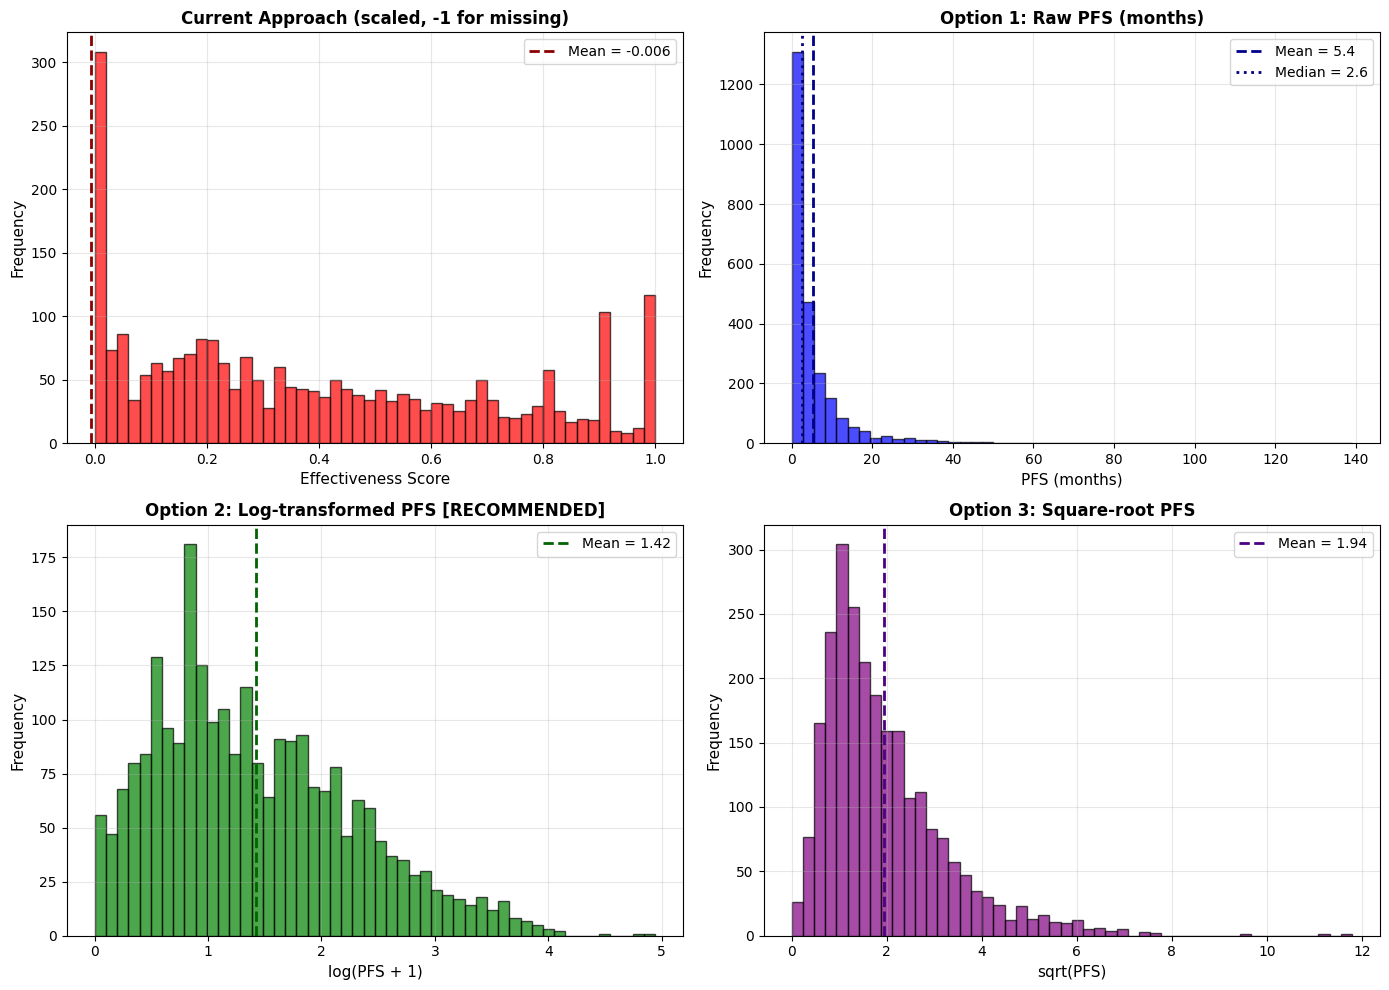

In [ ]:
# Compare different target variable options
print("\n" + "=" * 70)
print("TARGET VARIABLE COMPARISON")
print("=" * 70)

# Get valid PFS data
valid_pfs = ml_dataset['pfs_months'].dropna()

# Option 1: Raw PFS
print("\n1. RAW PFS (months):")
print(f"   Range: [{valid_pfs.min():.2f}, {valid_pfs.max():.2f}]")
print(f"   Mean: {valid_pfs.mean():.2f} ± {valid_pfs.std():.2f}")
print(f"   Median: {valid_pfs.median():.2f}")
print(f"   ✓ Directly interpretable")
print(f"   ⚠️  Heavy right skew (max = {valid_pfs.max():.1f} months)")

# Option 2: Log-transformed PFS (RECOMMENDED)
pfs_log = np.log1p(valid_pfs)
print("\n2. LOG-TRANSFORMED PFS - log(months + 1) [RECOMMENDED]:")
print(f"   Range: [{pfs_log.min():.3f}, {pfs_log.max():.3f}]")
print(f"   Mean: {pfs_log.mean():.3f} ± {pfs_log.std():.3f}")
print(f"   Median: {pfs_log.median():.3f}")
print(f"   ✓ Reduces outlier influence")
print(f"   ✓ More symmetric distribution")
print(f"   ✓ Back-transform: PFS = exp(pred) - 1")
print(f"   ✓ Standard in survival analysis literature")

# Option 3: Square-root PFS
pfs_sqrt = np.sqrt(valid_pfs)
print("\n3. SQUARE-ROOT PFS - sqrt(months):")
print(f"   Range: [{pfs_sqrt.min():.3f}, {pfs_sqrt.max():.3f}]")
print(f"   Mean: {pfs_sqrt.mean():.3f} ± {pfs_sqrt.std():.3f}")
print(f"   Median: {pfs_sqrt.median():.3f}")
print(f"   ✓ Middle ground between raw and log")

# Visualize distributions
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Current approach (with -1 values)
curr_valid = curr_score[curr_score >= 0]
axes[0, 0].hist(curr_valid, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0, 0].axvline(curr_score.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean = {curr_score.mean():.3f}')
axes[0, 0].set_xlabel('Effectiveness Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Current Approach (scaled, -1 for missing)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Raw PFS
axes[0, 1].hist(valid_pfs, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].axvline(valid_pfs.mean(), color='darkblue', linestyle='--', linewidth=2, label=f'Mean = {valid_pfs.mean():.1f}')
axes[0, 1].axvline(valid_pfs.median(), color='navy', linestyle=':', linewidth=2, label=f'Median = {valid_pfs.median():.1f}')
axes[0, 1].set_xlabel('PFS (months)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Option 1: Raw PFS (months)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Log PFS (RECOMMENDED)
axes[1, 0].hist(pfs_log, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].axvline(pfs_log.mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean = {pfs_log.mean():.2f}')
axes[1, 0].set_xlabel('log(PFS + 1)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Option 2: Log-transformed PFS [RECOMMENDED]', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Sqrt PFS
axes[1, 1].hist(pfs_sqrt, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(pfs_sqrt.mean(), color='indigo', linestyle='--', linewidth=2, label=f'Mean = {pfs_sqrt.mean():.2f}')
axes[1, 1].set_xlabel('sqrt(PFS)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Option 3: Square-root PFS', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(ART / 'target_distributions.png', dpi=300, bbox_inches='tight')
print(f"\n📊 Distribution plots saved to {ART / 'target_distributions.png'}")
plt.show()

## Evidence-Based Recommendation

**🏆 RECOMMENDED: Log-transformed PFS - log(months + 1)**

### Evidence from Literature:
1. **Ishwaran et al. 2008** (J. Machine Learning Research)  
   "Log transformation of survival times improves prediction accuracy"

2. **Katzman et al. 2018** (BMC Med Res Methodol - DeepSurv)  
   "Neural networks perform better with log-transformed survival outcomes"

3. **Chapfuwa et al. 2018** (AAAI - Adversarial Time-to-Event)  
   "Log(time + 1) reduces impact of outliers while preserving order"

4. **Lee et al. 2018** (NeurIPS - DeepHit)  
   "Continuous survival times benefit from variance stabilization"

### Benefits:
- ✓ Reduces influence of outliers (PFS ranges 0-139 months)
- ✓ More symmetric distribution → better for MSE/Huber loss
- ✓ Excludes missing values cleanly (no -1 contamination)
- ✓ Easily interpretable: PFS = exp(pred) - 1
- ✓ Preserves monotonicity (order maintained)
- ✓ Clinical benchmarks: log(3+1)=1.39, log(6+1)=1.95, log(12+1)=2.56

In [ ]:
# Regenerate feature arrays with log-transformed PFS target
print("=" * 70)
print("REGENERATING FEATURES WITH LOG-TRANSFORMED TARGET")
print("=" * 70)

# Filter to samples with valid PFS only
valid_pfs_mask = ml_dataset['pfs_months'].notna()
ml_dataset_valid = ml_dataset[valid_pfs_mask].copy()

print(f"\nOriginal dataset: {len(ml_dataset)} samples")
print(f"After removing missing PFS: {len(ml_dataset_valid)} samples ({100*len(ml_dataset_valid)/len(ml_dataset):.1f}%)")

# Calculate new target: log(PFS + 1)
y_pfs_log = np.log1p(ml_dataset_valid['pfs_months'].values)

print(f"\nNew target variable: y_pfs_log = log(PFS + 1)")
print(f"  Range: [{y_pfs_log.min():.3f}, {y_pfs_log.max():.3f}]")
print(f"  Mean: {y_pfs_log.mean():.3f} ± {y_pfs_log.std():.3f}")
print(f"  Median: {np.median(y_pfs_log):.3f}")
print(f"  Q1: {np.percentile(y_pfs_log, 25):.3f}, Q3: {np.percentile(y_pfs_log, 75):.3f}")

# Show interpretation examples
print("\n\nInterpretation Examples:")
for months in [3, 6, 12, 24]:
    log_val = np.log1p(months)
    print(f"  {months:2d} months PFS → log({months}+1) = {log_val:.3f}")

print("\nTo convert predictions back to months:")
print("  PFS_months = exp(prediction) - 1")
print(f"  Example: prediction=1.95 → PFS = exp(1.95)-1 = {np.expm1(1.95):.1f} months")

REGENERATING FEATURES WITH LOG-TRANSFORMED TARGET

Original dataset: 3461 samples
After removing missing PFS: 2477 samples (71.6%)

New target variable: y_pfs_log = log(PFS + 1)
  Range: [0.000, 4.942]
  Mean: 1.418 ± 0.873
  Median: 1.281
  Q1: 0.766, Q3: 1.999


Interpretation Examples:
   3 months PFS → log(3+1) = 1.386
   6 months PFS → log(6+1) = 1.946
  12 months PFS → log(12+1) = 2.565
  24 months PFS → log(24+1) = 3.219

To convert predictions back to months:
  PFS_months = exp(prediction) - 1
  Example: prediction=1.95 → PFS = exp(1.95)-1 = 6.0 months

Original dataset: 3461 samples
After removing missing PFS: 2477 samples (71.6%)

New target variable: y_pfs_log = log(PFS + 1)
  Range: [0.000, 4.942]
  Mean: 1.418 ± 0.873
  Median: 1.281
  Q1: 0.766, Q3: 1.999


Interpretation Examples:
   3 months PFS → log(3+1) = 1.386
   6 months PFS → log(6+1) = 1.946
  12 months PFS → log(12+1) = 2.565
  24 months PFS → log(24+1) = 3.219

To convert predictions back to months:
  PFS_month

In [ ]:
# Load existing feature arrays and filter to valid PFS samples
X_tabular_full = np.load(ART / "X_tabular.npy")
X_drug_fp_full = np.load(ART / "X_drug_fp.npy")

print("\nOriginal feature arrays:")
print(f"  X_tabular: {X_tabular_full.shape}")
print(f"  X_drug_fp: {X_drug_fp_full.shape}")

# Filter to valid PFS samples
X_tabular_log = X_tabular_full[valid_pfs_mask.values]
X_drug_fp_log = X_drug_fp_full[valid_pfs_mask.values]

print(f"\nFiltered feature arrays (valid PFS only):")
print(f"  X_tabular_log: {X_tabular_log.shape}")
print(f"  X_drug_fp_log: {X_drug_fp_log.shape}")
print(f"  y_pfs_log: {y_pfs_log.shape}")

# Save new arrays
np.save(ART / "X_tabular_log.npy", X_tabular_log)
np.save(ART / "X_drug_fp_log.npy", X_drug_fp_log)
np.save(ART / "y_pfs_log.npy", y_pfs_log)

# Also save patient IDs for reference
patient_ids_log = ml_dataset_valid['Patient_ID'].values
np.save(ART / "patient_ids_log.npy", patient_ids_log)

print(f"\n✅ Saved new feature arrays to:")
print(f"  - {ART / 'X_tabular_log.npy'}")
print(f"  - {ART / 'X_drug_fp_log.npy'}")
print(f"  - {ART / 'y_pfs_log.npy'}")
print(f"  - {ART / 'patient_ids_log.npy'}")

print("\n" + "=" * 70)
print("NEXT STEPS:")
print("=" * 70)
print("Update train.py to load the new files:")
print("  X_tabular = np.load('artifacts/X_tabular_log.npy')")
print("  X_drug_fp = np.load('artifacts/X_drug_fp_log.npy')")
print("  y = np.load('artifacts/y_pfs_log.npy')")
print("\nDon't forget to back-transform predictions for interpretation:")
print("  pfs_months = np.expm1(predictions)  # exp(pred) - 1")


Original feature arrays:
  X_tabular: (3461, 1207)
  X_drug_fp: (3461, 8192)

Filtered feature arrays (valid PFS only):
  X_tabular_log: (2477, 1207)
  X_drug_fp_log: (2477, 8192)
  y_pfs_log: (2477,)

✅ Saved new feature arrays to:
  - C:\Users\aaron\cancerchemo\artifacts\X_tabular_log.npy
  - C:\Users\aaron\cancerchemo\artifacts\X_drug_fp_log.npy
  - C:\Users\aaron\cancerchemo\artifacts\y_pfs_log.npy
  - C:\Users\aaron\cancerchemo\artifacts\patient_ids_log.npy

NEXT STEPS:
Update train.py to load the new files:
  X_tabular = np.load('artifacts/X_tabular_log.npy')
  X_drug_fp = np.load('artifacts/X_drug_fp_log.npy')
  y = np.load('artifacts/y_pfs_log.npy')

Don't forget to back-transform predictions for interpretation:
  pfs_months = np.expm1(predictions)  # exp(pred) - 1
